In [74]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print(rmsle_val)
    print(rmse_val)
    print(mae_val)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [76]:
import matplotlib
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 110
pd.set_option('display.max_columns', None)

train_df = pd.read_csv("../../data/bike/train.csv")
test_df = pd.read_csv("../../data/bike/test.csv")
santander_submission_df = pd.read_csv("../../data/bike/sampleSubmission.csv")

> - 2011년 1월 ~ 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안 자전거 대여 횟수 데이터가 있다.

> - datetime: hourly date + timestamp
> - season: 1 - 봄, 2 - 여름, 3- 가을, 4 - 겨울
> - holyday: 1 - 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 - 휴일이 아닌 날
> - workingday: 1 - 토, 일요일의 주말 및 휴일이 아닌 주중, 0 - 주말 및 휴일
> - weather:
> - - 1 = 맑음, 약간 구름 낀 흐림 / 2 = 안개, 안개 + 흐림 / 3 = 가벼운 눈, 가벼운 비 + 천둥 / 4 = 심한 눈/비, 천둥/번개
> - temp: 온도(섭씨)
> - atemp: 체감 온도(섭씨)
> - humidity: 상대 습도
> - windspeed: 풍속
> - casual: 사전에 등록되지 않은 사용자가 대여한 횟수
> - registered: 사전에 등록된 사용자가 대여한 횟수
> - count: 대여 횟수

In [77]:
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [79]:
train_df['datetime'] = train_df.datetime.apply(pd.to_datetime)

train_df['year'] = train_df.datetime.apply(lambda x: x.year)
train_df['month'] = train_df.datetime.apply(lambda x: x.month)
train_df['day'] = train_df.datetime.apply(lambda x: x.day)
train_df['hour'] = train_df.datetime.apply(lambda x: x.hour)

train_df.drop(['datetime'], axis=1, inplace=True)

In [80]:
train_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22


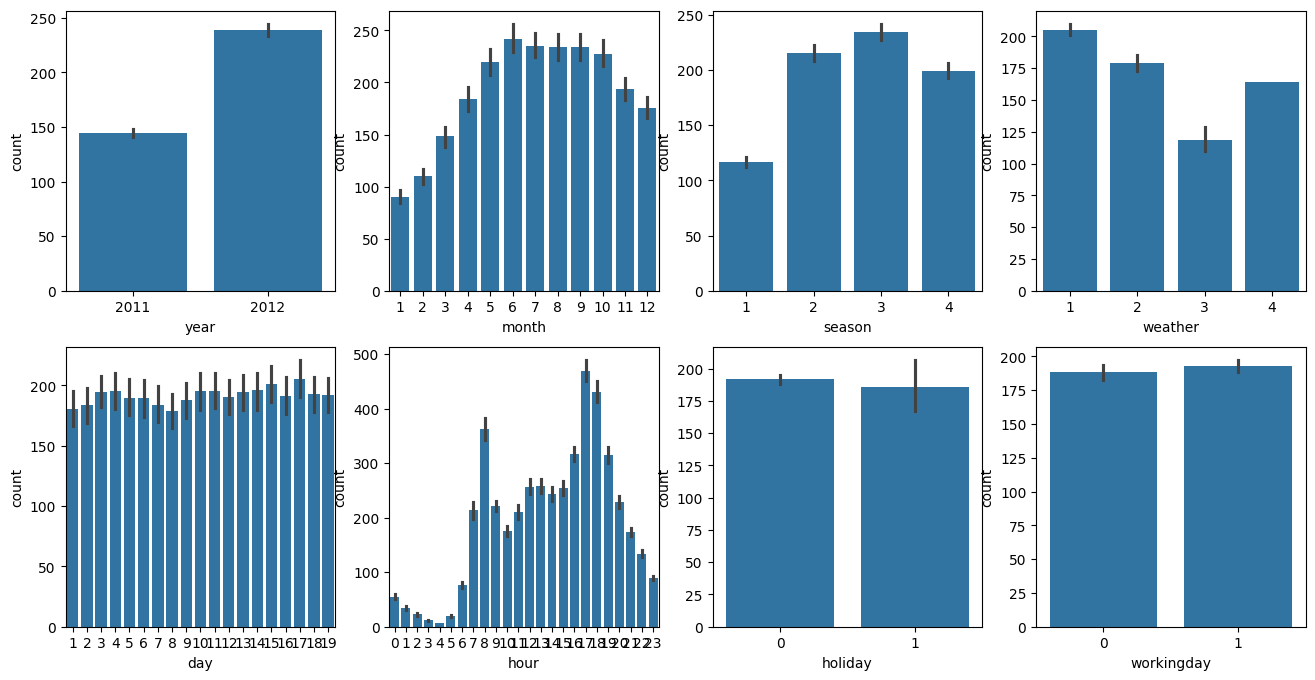

In [81]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']

for i, feature in enumerate(features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=train_df, ax=axs[row][col])

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

drop_columns = ['casual', 'registered']
y_target = train_df['count']
# X_features = train_df.drop(['count'],axis=1,inplace=False)
X_features = train_df.drop(drop_columns, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

3.874795402358897e-15
8.225564112455314e-14
4.946788029213318e-14
RMSLE: 0.000, RMSE: 0.000, MAE: 0.000


In [83]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count  diff
0            244            244.0   0.0
2181         311            311.0   0.0
2171         213            213.0   0.0
2172           7              7.0   0.0
2173         340            340.0   0.0


<Axes: >

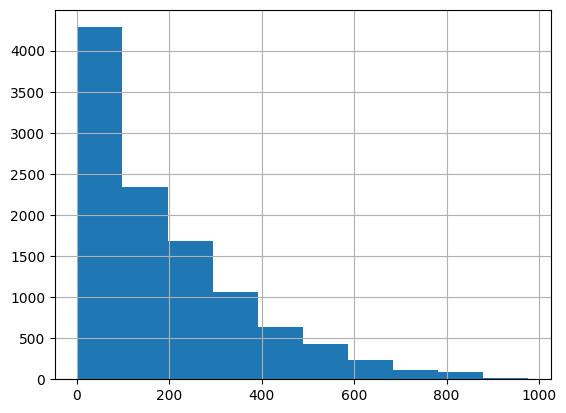

In [84]:
y_target.hist()

<Axes: >

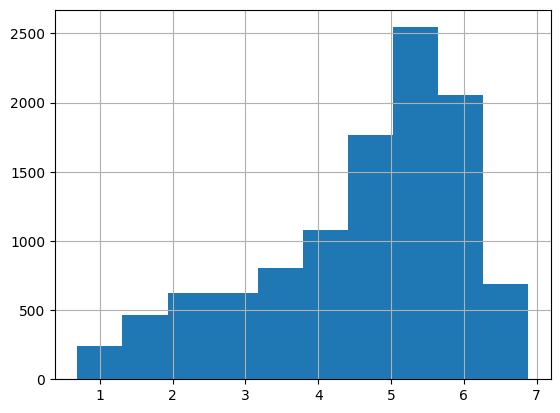

In [85]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [86]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test ,pred)

0.18081204013447236
0.7059112815206899
0.5437418749999956
RMSLE: 0.181, RMSE: 0.706, MAE: 0.544


<Axes: ylabel='None'>

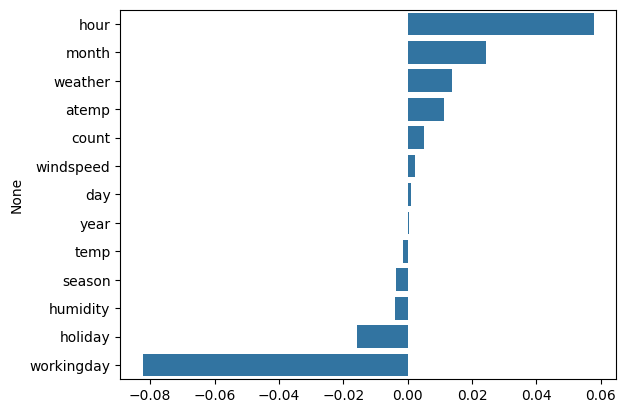

In [87]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [88]:
X_features_one = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [89]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features_one, y_target_log, test_size=0.3, random_state=0)


def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('\n###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
# alpha가 크면 회귀 계수 값을 작게 만든다. = L2
# 커질수록 정규화의 강도가 세지며, 회귀 계수들이 더욱 작아진다.
# 모든 피처의 계수를 작게 만들지만, 대부분의 계수는 0이 되지 않는다. 즉, 모든 피처를 사용하면서 과적합을 방지하려는 경우 유리

lasso_reg = Lasso(alpha=0.01)
# alpha가 회귀 계수의 절댓값 합을 비용 함수에 추가하여, 특정 계수를 0으로 만든다. = L1
# 커질수록 불필요한 피처의 계수가 0이 되어 모델이 더 간단해 진다.
# 일부 피처의 계수를 0으로 만들어 불필요한 피처를 제거한다. 즉, 변수 선택이 필요할 때 유리

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)


### LinearRegression ###
0.4782378604122378
123.72042718940378
50.66058917352296
RMSLE: 0.478, RMSE: 123.720, MAE: 50.661

### Ridge ###
0.4788526965210353
136.1448051492663
53.10894241507471
RMSLE: 0.479, RMSE: 136.145, MAE: 53.109

### Lasso ###
0.5318828180391573
248.00909434225886
78.75520130205776
RMSLE: 0.532, RMSE: 248.009, MAE: 78.755


<Axes: ylabel='None'>

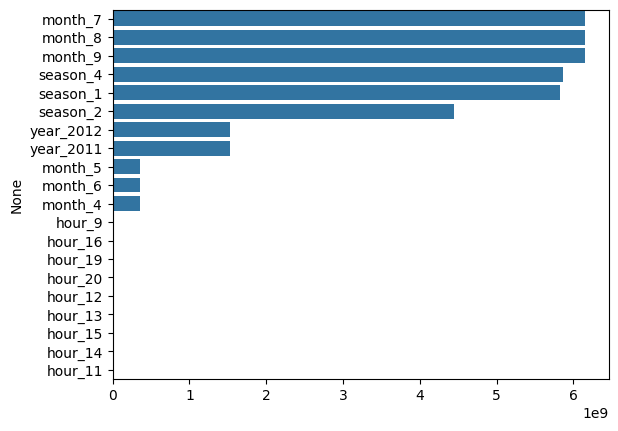

In [91]:
coef = pd.Series(lr_reg.coef_, index=X_features_one.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [93]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)


### RandomForestRegressor ###
0.0003860621363661423
0.30662847316706954
0.04830043968691087
RMSLE: 0.000, RMSE: 0.307, MAE: 0.048

### GradientBoostingRegressor ###
0.003948082360465437
1.1993569411984115
0.6530114874502443
RMSLE: 0.004, RMSE: 1.199, MAE: 0.653

### XGBRegressor ###
0.005136951925008478
2.2141988080459725
0.9217909179212732
RMSLE: 0.005, RMSE: 2.214, MAE: 0.922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 73
[LightGBM] [Info] Start training from score 4.582043

### LGBMRegressor ###
0.0052062785310249245
1.838977256843342
0.7373160573868134
RMSLE: 0.005, RMSE: 1.839, MAE: 0.737
